In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    "../data/processed/superstore_processed.csv",
    parse_dates=["Order Date", "Ship Date"]
)

df.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,26196.0,2,0.00,419136.0
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",73194.0,3,0.00,219582.0
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,1462.0,2,0.00,68714.0
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,9575775.0,5,0.45,-383031.0
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22368.0,2,0.20,25164.0


In [4]:
# Defining the Analysis Date
analysis_date = df["Order Date"].max() + pd.Timedelta(days=1)
analysis_date


Timestamp('2017-12-31 00:00:00')

In [6]:
# Build the RFM Table (Aggregate data per Customer)
rfm = (
    df.groupby("Customer ID")
    .agg({
        "Order Date": lambda x: (analysis_date - x.max()).days,
        "Order ID": "nunique",
        "Sales": "sum"
    })
    .reset_index()
)
rfm.columns = ["Customer ID", "Recency", "Frequency", "Monetary"]
rfm.head()


,Customer ID,Recency,Frequency,Monetary
0,AA-10315,185,5,5090484.0
1,AA-10375,20,9,165678.0
2,AA-10480,260,4,193048.0
3,AA-10645,56,6,1737756.0
4,AB-10015,416,3,143818.0


In [8]:
# Inspect RFM Values (Before Modeling)
rfm.describe()


,Recency,Frequency,Monetary
count,793.000000,793.000000,7.930000e+02
mean,147.802018,6.316520,1.425208e+06
std,186.211051,2.550885,1.961667e+06
min,1.000000,1.000000,1.652000e+03
25%,31.000000,5.000000,3.401300e+05
50%,76.000000,6.000000,8.328640e+05
75%,184.000000,8.000000,1.737733e+06
max,1166.000000,17.000000,2.490601e+07


In [9]:
# Handle Outlers
rfm["Monetary"] = np.log1p(rfm["Monetary"])


In [12]:
# Normalize RFM Value (Mandatory for K-means)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(
    rfm[["Recency", "Frequency", "Monetary"]]
)

rfm_scaled.shape



(793, 3)

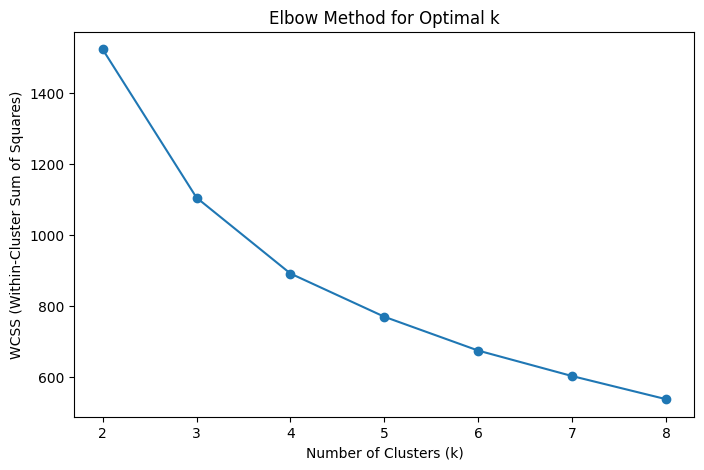

In [15]:
# Elbow Method

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow Method
wcss = []

for k in range(2, 9):  # testing 2 to 8 clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 9), wcss, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.show()


In [17]:
# Train final K-Means model
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

# Check cluster sizes
rfm["Cluster"].value_counts().sort_index()


Cluster
0    167
1     89
2    236
3    301
Name: count, dtype: int64

In [19]:
# Cluster Profiles
cluster_summary = (
    rfm.groupby("Cluster")
    .agg({
        "Recency": "mean",
        "Frequency": "mean",
        "Monetary": "mean"
    })
    .round(2)
)

cluster_summary


,Recency,Frequency,Monetary
Cluster,,,
0,122.31,4.34,11.77
1,580.11,3.83,12.89
2,77.85,9.42,14.17
3,88.97,5.72,14.03


In [21]:
# Lebel Clusters Properly
cluster_labels = {
    0: "Potential Loyalists",
    1: "At-Risk / Lost",
    2: "Champions",
    3: "Loyal Customers"
}

rfm["Customer_Segment"] = rfm["Cluster"].map(cluster_labels)

rfm[["Customer ID", "Recency", "Frequency", "Monetary", "Customer_Segment"]].head()


,Customer ID,Recency,Frequency,Monetary,Customer_Segment
0,AA-10315,185,5,15.442884,Loyal Customers
1,AA-10375,20,9,12.017807,Champions
2,AA-10480,260,4,12.170699,Potential Loyalists
3,AA-10645,56,6,14.368106,Loyal Customers
4,AB-10015,416,3,11.876311,At-Risk / Lost


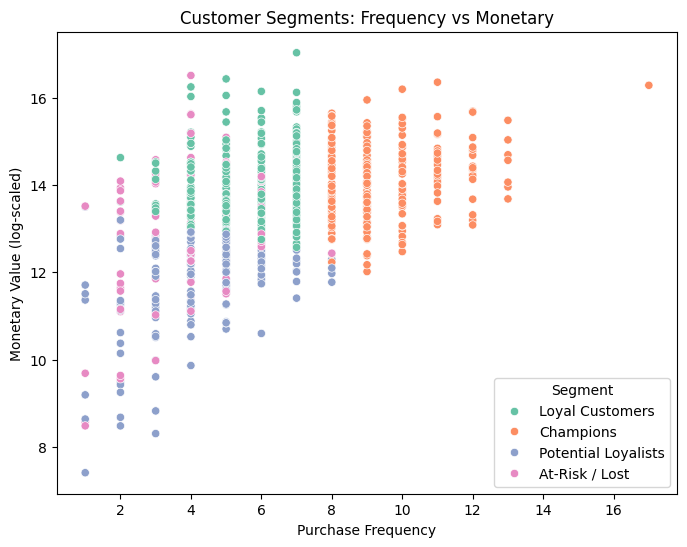

In [23]:
# 2D Visualization (Frequency vs Monetary)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm,
    x="Frequency",
    y="Monetary",
    hue="Customer_Segment",
    palette="Set2"
)

plt.title("Customer Segments: Frequency vs Monetary")
plt.xlabel("Purchase Frequency")
plt.ylabel("Monetary Value (log-scaled)")
plt.legend(title="Segment")
plt.show()


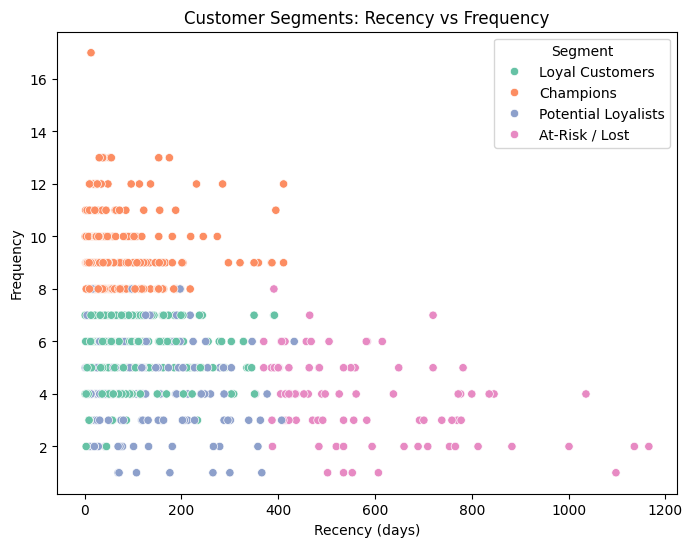

In [32]:
# Recency vs Frequency (Behavioral View)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm,
    x="Recency",
    y="Frequency",
    hue="Customer_Segment",
    palette="Set2"
)

plt.title("Customer Segments: Recency vs Frequency")
plt.xlabel("Recency (days)")
plt.ylabel("Frequency")
plt.legend(title="Segment")
plt.show()


In [34]:
rfm.columns.tolist()


['Customer ID',
 'Recency',
 'Frequency',
 'Monetary',
 'Cluster',
 'Customer_Segment',
 'Profit_x',
 'Discount_x',
 'Profit_y',
 'Discount_y',
 'Profit',
 'Discount']

In [39]:
customer_financials = (
    df.groupby("Customer ID", as_index=False)
    .agg(
        Profit=("Profit","sum"),
        Discount=("Discount", "mean")
    )
)

customer_financials.head()

,Customer ID,Profit,Discount
0,AA-10315,-6775855.0,0.090909
1,AA-10375,2189580.0,0.080000
2,AA-10480,4358274.0,0.016667
3,AA-10645,2154130.0,0.063889
4,AB-10015,1293465.0,0.066667


In [41]:
rfm[["Profit", "Discount"]].describe()

,Profit,Discount
count,7.930000e+02,793.000000
mean,2.265959e+06,0.157454
std,6.508430e+06,0.089097
min,-4.121845e+07,0.000000
25%,1.931960e+05,0.090909
50%,1.345217e+06,0.150000
75%,3.205016e+06,0.211111
max,6.917082e+07,0.700000


In [49]:
rfm.columns.tolist()

['Customer ID',
 'Recency',
 'Frequency',
 'Monetary',
 'Cluster',
 'Customer_Segment',
 'Profit',
 'Discount']

In [51]:
segment_financials = (
    rfm.groupby("Customer_Segment")
    .agg(
        Avg_Profit=("Profit", "mean"),
        Avg_Discount=("Discount", "mean"),
        Customer_Count=("Customer ID", "count")
    )
    .round(2)
)

segment_financials

,Avg_Profit,Avg_Discount,Customer_Count
Customer_Segment,,,
At-Risk / Lost,1406118.79,0.17,89
Champions,3121913.55,0.16,236
Loyal Customers,2434018.06,0.16,301
Potential Loyalists,1211678.09,0.14,167


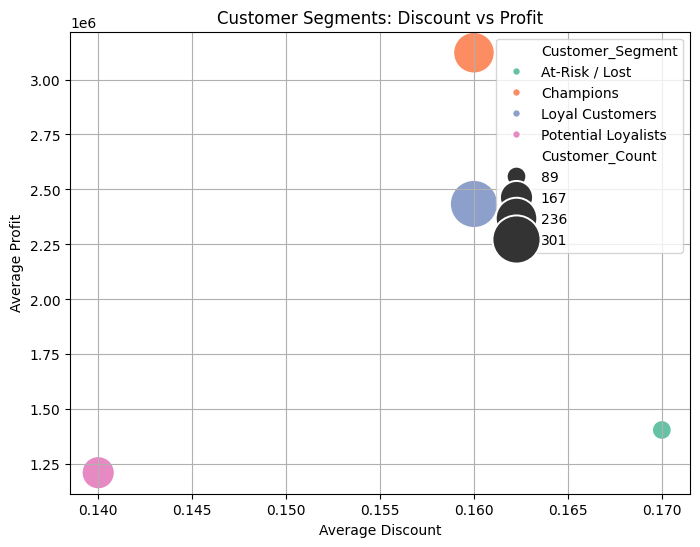

In [52]:
# Visualize Discounts vs Profit by Segment
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=segment_financials.reset_index(),
    x="Avg_Discount",
    y="Avg_Profit",
    size="Customer_Count",
    hue="Customer_Segment",
    sizes=(200, 1200),
    palette="Set2",
    legend=True
)

plt.title("Customer Segments: Discount vs Profit")
plt.xlabel("Average Discount")
plt.ylabel("Average Profit")
plt.grid(True)
plt.show()
